In [70]:
import networkx as nx
from scipy.stats import poisson
import itertools
from tqdm import tqdm
from seirsplus.models import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

### Specifying parameters from Tucker model

In [2]:
n_pop = 18700

# Isoboxes
n_isoboxes = 810
pop_isoboxes = 8100
pop_per_isobox = 10

# Tents
n_tents = 2650
pop_tents = 10600
pop_per_tent = 4

# Others 
n_bathrooms = 144
n_ethnic_groups = 8

### Assigning population to isoboxes

In [ ]:
max_pop_per_isobox = poisson.rvs(mu=10, size=812)

In [ ]:
max_pop_per_isobox[:10]

In [ ]:
g = nx.Graph()
isobox_num = 812
n_ethnicities = 8
iso_count = np.zeros(shape=(isobox_num ))
nodes_per_isobox = [[] for i in range(isobox_num)]

for node in range(pop_isoboxes):
    g.add_node(node)
    
    iso_num = np.random.choice(range(isobox_num))
    while iso_count[iso_num] == max_pop_per_isobox[iso_num]:
        iso_num = np.random.choice(range(isobox_num))
    
    g.nodes[node]["isobox_num"] = iso_num
    g.nodes[node]["ethnicity"] = np.random.choice(range(n_ethnicities))
    iso_count[iso_num] += 1
    
    nodes_per_isobox[iso_num].append(node)


### Add connections between people from the same isobox

In [ ]:
for node_list in nodes_per_isobox:
    edge_list = [tup for tup in list(itertools.product(node_list, repeat=2)) if tup[0] != tup[1]]
    g.add_edges_from(edge_list)

In [ ]:
nodes_per_isobox[809]

### Create FRIENDSHIP GRID: Match nodes that share the same ethnicity with nodes of neighboring isoboxes

In [ ]:
width = 29
height = 28
iso_grid = np.zeros(shape=(width, height)).astype(int)
iso_n = 0

for i in range(width):
    for j in range(height):
        iso_grid[i][j] = iso_n
        iso_n += 1
iso_grid

In [ ]:
def get_iso_neighbors(grid, isobox, iso_proximity):
    """ Given a grid of isobox numbers, returns the closest proximity neighbors to the given isobox
    
        params:
        - Grid: 2D numpy array
        - isobox: int
        - proximity: int
    """
    
    iso_neighbors = set()
    
    for i in range(-iso_proximity, iso_proximity + 1):
        for j in range(-iso_proximity, iso_proximity + 1):
            if not (i == 0 and j == 0):    
                x = min(max((isobox // height) - i, 0), width-1)
                y = min(max((isobox % height) - j, 0), height-1)
                
                if iso_grid[x][y] != isobox:
                    iso_neighbors.add(iso_grid[x][y])
    
    return list(iso_neighbors)

In [ ]:
# Assumption: people of same node properties interact if they are within close (variable=1) isobox proximity
iso_proximity = 2
isobox = 27
isobox_neighbors = get_iso_neighbors(iso_grid, isobox, iso_proximity)
isobox_neighbors.sort()
isobox_neighbors

In [ ]:
def connect_with_neighbors(graph, iso_grid, iso_proximity):
    """
        TEMPORARY: Only connect nodes that share the same ethnicity
        TODO: Don't add edges if we have added them already (don't search for things twice?)
    """
    
    
    # For every possible isobox:
    for isobox in range(n_isoboxes):
        
        # Get all the nodes in the current isobox
        #nodes = [node for node, attr in graph.nodes(data=True) if attr["isobox_num"] == isobox]
        nodes = [g.nodes[i] for i in nodes_per_isobox[isobox]]
        
        # Get the coordinates of the isobox in the grid
        #isobox_coords = (np.where(iso_grid == isobox)[0][0], np.where(iso_grid == isobox)[1][0])
        
        # Given its isobox number and coordinates in the iso grid, get its neighbor isoboxes
        isobox_neighbors = get_iso_neighbors(iso_grid, isobox, iso_proximity)
        
        # For every neighbor isobox:
        for iso_neighbor in isobox_neighbors:
            
            # Get all the nodes in that isobox neighbor
            try:
                neighbor_nodes = [g.nodes[i] for i in nodes_per_isobox[iso_neighbor]]
            except:
                print(iso_neighbor)
            
            # If they share the same properties, draw an edge between them
            graph.add_edges_from([(i, j) for i in nodes_per_isobox[isobox] \
                                  for j in nodes_per_isobox[iso_neighbor] if g.nodes[i]["ethnicity"] == g.nodes[j]["ethnicity"]])
            
    

In [ ]:
connect_with_neighbors(g, iso_grid, iso_proximity)

In [ ]:
g.nodes[nodes_per_isobox[0][0]], nodes_per_isobox[0][0]

In [ ]:
connected_bois = [edge[1] for edge in g.edges if edge[0] == 678]

In [ ]:
[g.nodes[cb] for cb in connected_bois]

## Connecting people that go to the food line

In [ ]:
food_bois = set()

for iso_list in nodes_per_isobox:
    the_chosenone = np.random.choice(iso_list)
    the_chosentwo = np.random.choice(iso_list)
    
    food_bois.add(the_chosenone)
    food_bois.add(the_chosentwo) 

food_bois = list(food_bois)

In [ ]:
np.random.shuffle(food_bois)

In [ ]:
for i in range(len(food_bois) - 1):
    g.add_edge(food_bois[i], food_bois[i+1])

In [ ]:
food_bois[0]

In [ ]:
connected_bois = [edge[1] for edge in g.edges if edge[0] == 802]
[g.nodes[cb] for cb in connected_bois]

## Make everything usable and modular

In [2]:
def create_graph(n_structures, population, max_pop_per_struct, edge_weight):
    """ Creates a networkX graph containing all the population in the camp that is in a given structure (currently just isoboxes). 
        Draws edges between people from the same isobox and returns the networkX graph and an adjacency list 
    """
    # For now we will only add ethnicity as a node property, but we can expand on this
    n_ethnicities = 8
    
    # Graph is a networkX graph object
    g = nx.Graph()
    
    # Keep track of how many nodes we have put in an isobox already
    struct_count = np.zeros(shape=(n_structures))
    
    # Store the indices of the nodes we store in each isobox in a 2D array where array[i] contains the nodes in isobox i
    nodes_per_struct = [[] for i in range(n_structures)]
    
    available_structs = list(range(n_structures))
    
    # Add the nodes to the graph
    for node in tqdm(range(population)):
        g.add_node(node)
        
        # Assign nodes to isoboxes randomly, until we reach the capacity of that isobox
        struct_num = np.random.choice(available_structs)
        
        # Assign properties to nodes
        g.nodes[node]["location"] = struct_num
        g.nodes[node]["ethnicity"] = np.random.choice(range(n_ethnicities)) 
        
        # Update number of nodes per isobox and which nodes were added to iso_num
        struct_count[struct_num] += 1
        nodes_per_struct[struct_num].append(node)
        
        if struct_count[struct_num] > max_pop_per_struct[struct_num]:
            available_structs.remove(struct_num)
    
    
    # Now we connect nodes inside of the same isobox
    for node_list in nodes_per_struct:
        
        # Use the cartesian product to get all possible edges within the nodes in an isobox and only add if they are not the same node 
        edge_list = [tup for tup in list(itertools.product(node_list, repeat=2)) if tup[0] != tup[1]]
        g.add_edges_from(edge_list, weight=edge_weight)
    
    return g, nodes_per_struct

In [3]:
def create_grid(width, height):
    """ Create a grid of isoboxes that resembles the isobox area of the camp, for ease of measuring proximity between nodes 
        Returns a numpy array of shape (width, height) """
    
    iso_grid = np.zeros(shape=(width, height)).astype(int)
    iso_n = 0

    for i in range(width):
        for j in range(height):
            iso_grid[i][j] = iso_n
            iso_n += 1
    
    return iso_grid

In [4]:
def get_neighbors(grid, structure_num, proximity):
    """ Given a grid of structures, returns the closest proximity neighbors to the given structure
    
        params:
        - Grid: 2D numpy array
        - structure_num: int
        - proximity: int
    """
    
    # Get the number of columns for ease of access
    width = len(grid)
    height = len(grid[0])
    
    # We'll make it a set initially to avoid duplicate neighbors
    neighbors = set()
    
    for i in range(-proximity, proximity + 1):
        for j in range(-proximity, proximity + 1):
            if not (i == 0 and j == 0):    
                x = min(max((structure_num// height) - i, 0), width-1)
                y = min(max((structure_num % height) - j, 0), height-1)
                
                if grid[x][y] != structure_num:
                    neighbors.add(grid[x][y])
    
    return list(neighbors)

In [5]:
def connect_neighbors(graph, n_structures, nodes_per_structure, grid, proximity, edge_weight):
    """ Draw edges in the given graph between people of neighboring structures (currently isoboxes) if they have the same ethnicity """
    
    # For every possible structure:
    for structure in range(n_structures):
        
        # Get all the nodes in the current structure
        nodes = [graph.nodes[i] for i in nodes_per_structure[structure]]
        
        # Given its isobox number get its neighbor isoboxes
        neighbors = get_neighbors(grid, structure, proximity)
        
        # For every neighbor isobox:
        for neighbor in neighbors:
            
            # Get all the nodes in that isobox neighbor
            neighbor_nodes = [graph.nodes[i] for i in nodes_per_structure[neighbor]]

            # If they share the same properties, draw an edge between them
            graph.add_edges_from([(i, j) for i in nodes_per_structure[structure] \
                                  for j in nodes_per_structure[neighbor] if graph.nodes[i]["ethnicity"] == graph.nodes[j]["ethnicity"]], weight=edge_weight)
            
    return graph

In [6]:
def connect_food_queue(graph, nodes_per_structure, edge_weight):
    """ Connect 1-2 people per structure (currently just isoboxes) randomly to represent that they go to the food queue 
        We have 3 options:
            - Either have a range of people (2-5 per isobox) that go to food queue, same edge weights
            - Connect all people in the food queue, same edge weights
            - Connect all people in food queue with different edge weights
    """
    
    food_bois = set()
    
    # Choose half of the people randomly from each structure
    for node_list in nodes_per_structure:
        for i in range(len(node_list)//2):
            food_bois.add(np.random.choice(node_list)) 
    
    # This list represents the food queue
    food_bois = list(food_bois)
    np.random.shuffle(food_bois)
    
    # Draw an edge between everyone in the list in order, since we have already shuffled them
    for i in range(len(food_bois)-6):
        for j in range(i+1, i+6):
            if not graph.has_edge(food_bois[i], food_bois[j]):
                graph.add_edge(food_bois[i], food_bois[j], weight=edge_weight)
        
    return graph
    

In [29]:
# Some helper functions
def min_degree(graph):
    return min(graph.degree, key=lambda kv: kv[1])[1]

def max_degree(graph):
    return max(graph.degree, key=lambda kv: kv[1])[1]

In [7]:
n_pop = 18700

# Isoboxes
n_isoboxes = 812
pop_isoboxes = 8100
pop_per_isobox = 10
max_pop_per_isobox  = poisson.rvs(mu=pop_per_isobox, size=n_isoboxes) # According to the model, this is drawn through a poison distribution

# Tents
n_tents = 2650
pop_tents = 10600
pop_per_tent = 4

# Others 
n_bathrooms = 144
n_ethnic_groups = 8

# Isobox grid parameters - can be extended to tents as well
grid_width = 29
grid_height = 28

# We define neighboring isoboxes as any isobox within a range of 2 in the isobox grid
iso_proximity = 2

In [8]:
# 1. Create isobox graph - can be used to create tent graphs as well
isoweight = 1
graph, nodes_per_isobox = create_graph(n_isoboxes, pop_isoboxes, max_pop_per_isobox, isoweight)

100%|██████████| 8100/8100 [00:00<00:00, 12331.05it/s]


In [9]:
# 2. Create the grid that will help with positioning when measuring proximity
isobox_grid = create_grid(grid_width, grid_height)

In [10]:
# 3. Connect the nodes that are within a certain degree of proximity - can be used for tents as well
neighborweight = 0.5
graph = connect_neighbors(graph, n_isoboxes, nodes_per_isobox, isobox_grid, iso_proximity, neighborweight)

In [11]:
# 4. Connect the nodes that go to the food line - can be extended to all nodes
foodweight = 0.2
graph = connect_food_queue(graph, nodes_per_isobox, foodweight)

# Check the lowest number of connections that exist in the graph!
print("Min degree of a node is", min_degree(graph))

In [19]:
# 5. Adding age/sex/death dataframe info

# Death rate per age calculation - parameters found by fitting a sigmoid curve
A_MALES = -9.58814632
B_MALES = 0.61453804
A_FEMALES = -9.91023535
B_FEMALES = 0.47451181

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def deathrate_male(x):
    return sigmoid(np.sqrt(x) + A_MALES) * B_MALES

def deathrate_female(x):
    return sigmoid(np.sqrt(x) + A_FEMALES) * B_FEMALES

def get_deathrate(row):
    if row["sex"] == 0:
        return deathrate_male(row["age"])
    
    else:
        return deathrate_female(row["age"])

In [26]:
# Dataframe including age (V1) and sex (V2)
pop_df = pd.read_csv('data/age_and_sex.csv')
pop_df = pop_df[["V1", "V2"]].rename(columns={"V1": "age", "V2": "sex"})

# Sample only the number of people in isoboxes
pop_df['death_rate'] = pop_df.apply(lambda row: get_deathrate(row), axis=1)
sample = pop_df.sample(n=pop_isoboxes, random_state=69420)
sample['death_rate'].values.shape

(8100,)

In [31]:
min_G, max_G = min_degree(graph), max_degree(graph)
min_G, max_G

(15, 69)

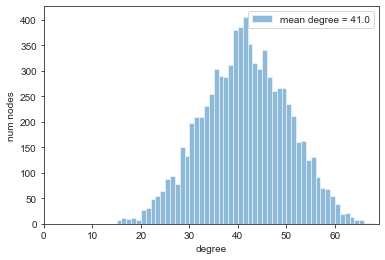

In [27]:
# Plot the degrees of the normal/default graph
plot_degree_distn(graph, max_degree=max_G)

In [66]:
# 6. Setting up a quarantine/social distancing graph 
# NOTE: We should tweak the reduction scale depending on what we want our mean degree to be

reduction_scale = 20 # Exponential distribution parameter. Setting it to 20 gives a mean of ~10, when the past mean was ~40
min_neighbors = 5 # The minimum number of connections that a person would hold in a distancing/quarantine scenario
Q = custom_exponential_graph(graph, scale=reduction_scale, min_num_edges=min_neighbors)

In [67]:
min_Q, max_Q = min_degree(Q), max_degree(Q)
min_Q, max_Q

(0, 39)

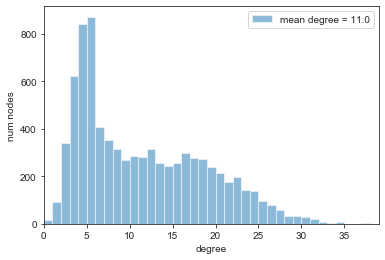

In [68]:
plot_degree_distn(Q, max_degree=max_Q)

In [72]:
# 7. Create checkpoints
checkpoints = defaultdict(list)

In [74]:
# Initialize empty checkpoints
checkpoints["t"] = []
checkpoints["G"] = []

In [23]:
beta = 1.28
sigma = 1/5.1
gamma = 0.056
initI = 10

ref_model = SEIRSNetworkModel(G=graph, beta=beta, sigma=sigma, gamma=gamma, mu_I=list(sample["death_rate"]), p=0.5,
                          beta_D=beta, sigma_D=sigma, gamma_D=gamma, mu_D=list(sample["death_rate"]),
                          theta_E=0, theta_I=0, phi_E=0, phi_I=0, psi_E=1.0, psi_I=1.0, q=0.5,
                          initI=10)

fig_name = f"Infections_IsoWeight={isoweight}_NeighWeight={neighborweight}_FoodWeight={foodweight}_Beta={beta}_Gamma={gamma}_Sigma={sigma}_initI={initI}"
ref_model.run(T=300)

t = 0.04
t = 10.00
t = 20.00
t = 30.00
t = 40.00
t = 50.02
t = 60.00
t = 70.02
t = 80.02
t = 90.10
t = 100.37
t = 110.27
t = 140.33


True

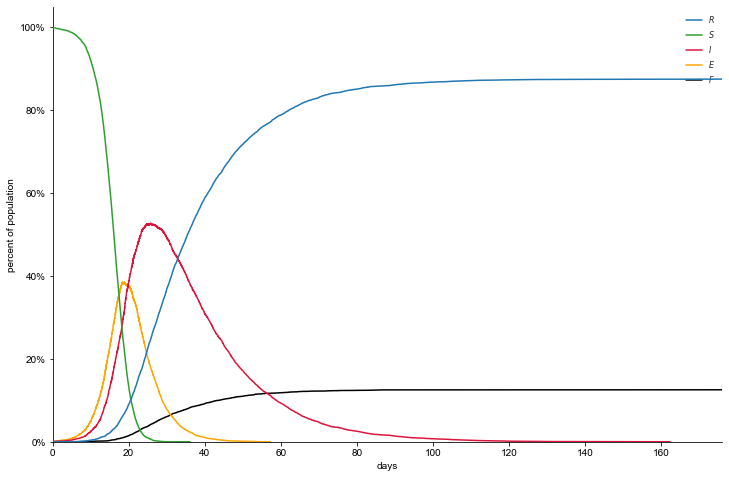

In [24]:
fig, ax = ref_model.figure_basic()
fig.savefig(f"{fig_name}_figBasic.png")

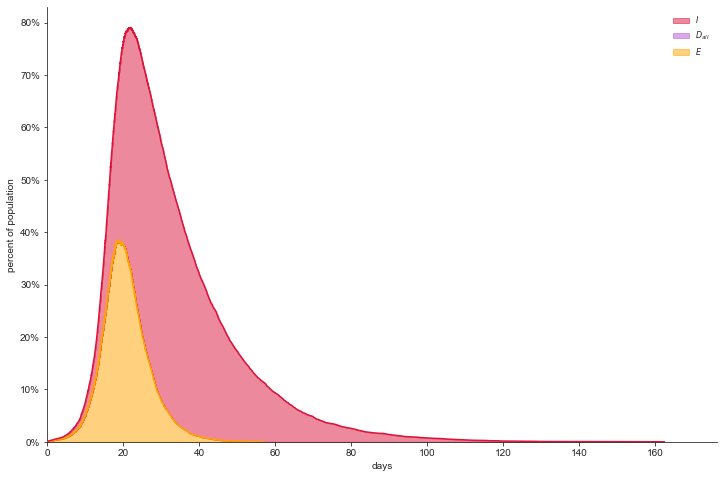

In [25]:
fig, ax = ref_model.figure_infections()
fig.savefig(f"{fig_name}_figInfections.png")

### Adding age, sex, deathrate

In [14]:
# Death rate per age calculation - parameters found by fitting a sigmoid curve
A_MALES = -9.58814632
B_MALES = 0.61453804
A_FEMALES = -9.91023535
B_FEMALES = 0.47451181

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def deathrate_male(x):
    return sigmoid(np.sqrt(x) + A_MALES) * B_MALES

def deathrate_female(x):
    return sigmoid(np.sqrt(x) + A_FEMALES) * B_FEMALES

def get_deathrate(row):
    if row["sex"] == 0:
        return deathrate_male(row["age"])
    
    else:
        return deathrate_female(row["age"])

In [15]:
# Dataframe including age (V1) and sex (V2)
pop_df = pd.read_csv('data/age_and_sex.csv')
pop_df = pop_df[["V1", "V2"]].rename(columns={"V1": "age", "V2": "sex"})
pop_df.head()

,age,sex
0,2.1,1
1,25.6,0
2,23.6,0
3,49.6,1
4,28.6,0


In [16]:
#pop_isoboxes
pop_df['death_rate'] = pop_df.apply(lambda row: get_deathrate(row), axis=1)
sample = pop_df.sample(n=pop_isoboxes, random_state=69420)
sample

,age,sex,death_rate
9814,18.0,1,0.001634
4134,3.6,0,0.000281
11848,6.1,1,0.000278
5922,13.8,0,0.001724
10323,34.0,0,0.014022
2710,20.8,1,0.002243
6024,42.8,0,0.027895
6497,26.0,0,0.006825
9524,21.7,1,0.002472
4397,23.8,0,0.005486


In [17]:
sample['death_rate'].values.shape

(8100,)